In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3-Sigma / Z-score example

移动平均与标准差带 (3-Sigma / Z-score 方法)

这是最常用、最经典的方法之一，可以看作是您想法的一个标准化实现。

- 核心思想：认为在一定时间窗口内，数据应该在均值附近的一定范围内波动。如果某个点远远偏离了这个范围，它就是异常的。

- 实时监测步骤：

    1. 计算移动均值 (Moving Average, μ)：计算时间点 $x$ 之前的 $n$ 个数据点 (从 $x-n$ 到 $x-1$) 的平均值。

    2. 计算移动标准差 (Moving Standard Deviation, σ)：计算这 $n$ 个数据点的标准差。

    3. 判断最新值：获取最新的数据点 $y_x$，计算它与均值的偏离程度，通常用 Z-score 公式：

$$
Z = \frac{\left | y_x - μ \right | }{σ}
$$


    4. 设定阈值：如果 Z-score 超出一个预设的阈值（通常是 2.5 或 3），则将 $y_x$ 标记为异常。这背后的统计学意义是，如果数据大致服从正态分布，99.7% 的数据点都应该落在距离均值 3 个标准差的范围内。

- 优点：

    - 标准化：Z-score 提供了一个标准化的、无量纲的指标来判断“偏离程度”，比直接比较方差更具普适性。

    - 效果稳健：对于图中所示的尖峰型异常检测效果非常好。


https://g.co/gemini/share/3a54994c8372

In [15]:
def detect_anomalies_zscore_example(
    data: pd.DataFrame, window_size: int = 30, threshold: float = 3.0
):
    """
    使用 3-Sigma (Z-score) 方法检测时间序列中的异常点。

    参数:
    data (pd.DataFrame): 包含时间序列数据的 Pandas Series，索引最好是时间。
    window_size (int): 用于计算均值和标准差的滚动窗口大小。
    threshold (float): 判断是否为异常的 Z-score 阈值。

    返回:
    pd.Series: 一个布尔值的 Series，其中 True 表示对应索引的数据是异常点。
    """
    # 1. 计算滚动均值
    rolling_mean = data.rolling(window=window_size, center=True).mean()

    # 2. 计算滚动标准差
    rolling_std = data.rolling(window=window_size, center=True).std()

    # 3. 计算 Z-score
    # 我们用当前值减去滚动均值，然后除以滚动标准差
    z_scores = np.abs((data - rolling_mean) / rolling_std)

    # 为了处理窗口开始和结束时无法计算的 NaN 值，我们用 0 填充
    z_scores.fillna(0)

    # 4. 根据阈值识别异常
    anomaly_ids = z_scores > threshold

    return anomaly_ids, rolling_mean, rolling_std

In [16]:
# --- 主程序：生成模拟数据并应用检测算法 ---

# 1. 生成模拟数据
# 创建一个与您图中类似的时间序列
np.random.seed(42)
time_index = pd.to_datetime(
    pd.date_range(start="2025-07-14 08:30", periods=300, freq="min")
)
# 正常波动
normal_fluctuation = np.random.randn(300) * 0.015 + 0.04
data_series = pd.Series(normal_fluctuation, index=time_index)

# 添加一些异常点（类似图中的大波动）
data_series["2025-07-14 09:40"] = -0.05
data_series["2025-07-14 10:35"] = 0.12
data_series["2025-07-14 11:20"] = -0.04
data_series["2025-07-14 12:51"] = 0.13

In [17]:
# 2. 调用函数进行异常检测
# 窗口大小可以根据你数据的采样频率调整，例如如果每秒一个点，窗口可以更大
window_size = 20
# 阈值通常选择 3，可以根据需要调整
z_threshold = 3.0

anomaly_ids, mean_line, std_line = detect_anomalies_zscore_example(
    data_series, window_size, z_threshold
)

# 打印出检测到的异常点的时间和数值
print("检测到的异常点: ", data_series[anomaly_ids])

检测到的异常点:  2025-07-14 09:40:00   -0.050000
2025-07-14 10:35:00    0.120000
2025-07-14 11:20:00   -0.040000
2025-07-14 11:59:00    0.097791
2025-07-14 12:51:00    0.130000
dtype: float64


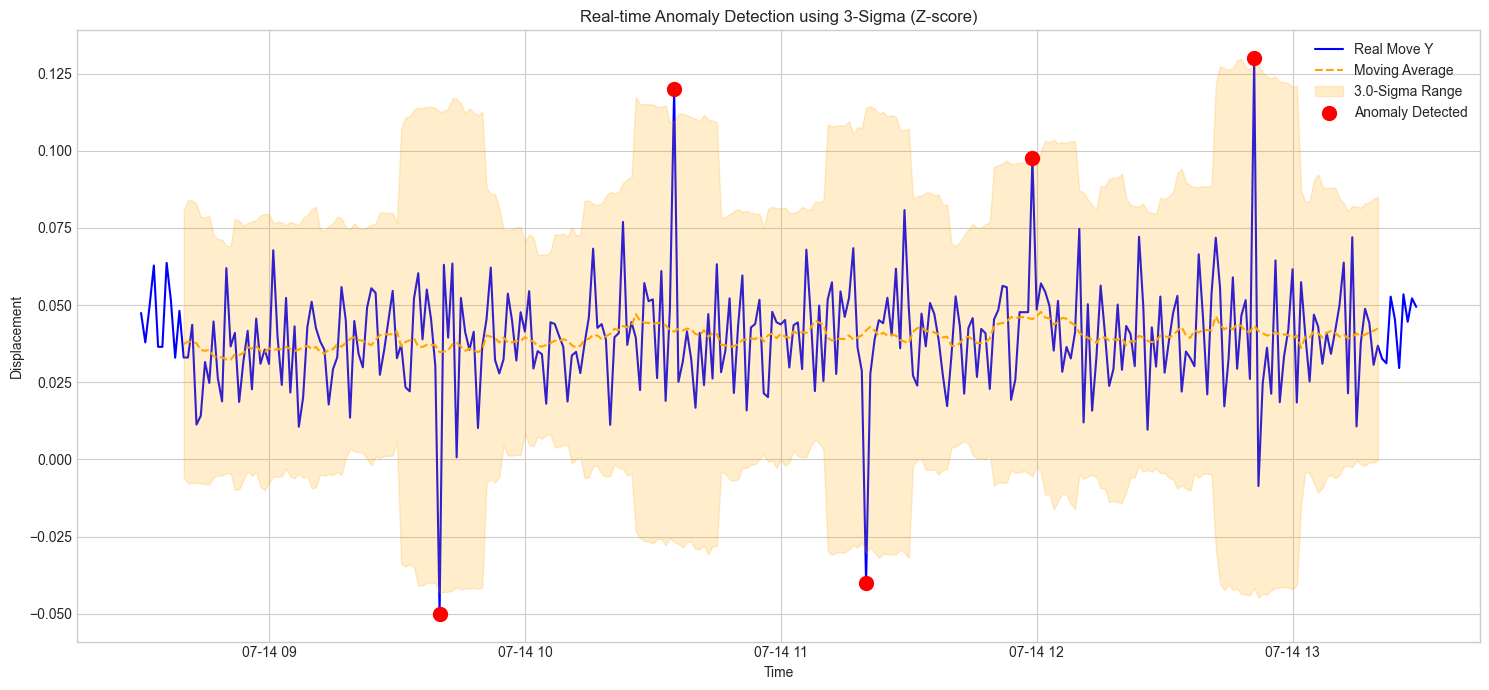

In [18]:
# 3. 结果可视化
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 7))

# 绘制原始数据
plt.plot(data_series.index, data_series, label="Real Move Y", color="blue", zorder=1)

# 绘制移动平均线
plt.plot(
    mean_line.index,
    mean_line,
    label="Moving Average",
    color="orange",
    linestyle="--",
    zorder=2,
)

# 绘制 3-Sigma 上下界
upper_bound = mean_line + (std_line * z_threshold)
lower_bound = mean_line - (std_line * z_threshold)
plt.fill_between(
    mean_line.index,
    lower_bound,
    upper_bound,
    color="orange",
    alpha=0.2,
    label=f"{z_threshold}-Sigma Range",
)

# 标记出检测到的异常点
plt.scatter(
    data_series[anomaly_ids].index,
    data_series[anomaly_ids],
    color="red",
    s=100,
    zorder=3,
    label="Anomaly Detected",
)

# 图表美化
plt.title("Real-time Anomaly Detection using 3-Sigma (Z-score)")
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend()
plt.tight_layout()
plt.show()